In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from datetime import datetime
import copy

def plotsize(x,y):
    sns.set(rc={'figure.figsize':(x,y)})
    
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
from torch.nn import BCELoss, NLLLoss, MSELoss, CrossEntropyLoss
from torch.utils.data import Dataset

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 400)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
%%html 
<style>.dataframe td { white-space: nowrap; } </style> 

In [5]:
def moving_average(values, window_size=30):
    cum_sum = [0]
    moving_averages = []
    for i, x in enumerate(values, 1):
        cum_sum.append(cum_sum[-1] + x)
        if i >= window_size:
            moving_avg = (cum_sum[-1] - cum_sum[-1 - window_size]) / window_size
            moving_averages.append(moving_avg)
        else:
            moving_averages.append(cum_sum[-1] / i)

    return np.array(moving_averages)

# Data preparation

## Data loading

- load data
- get only some subset
- add necessary fields
- filter only customers with enough transactions

In [6]:
pd.set_option('display.max_columns', None)

In [8]:
df = pd.read_csv('../data/czech_banking_dataset.csv', low_memory=False)

df['datetime'] = pd.to_datetime(df.date)
df = df[['trans_id', 'direction', 'type', 'client_id', 'amount', 'datetime']]
df['timestamp'] = df['datetime'].astype('datetime64[ns]').astype('int64') // 10**9

# create the sine and cosine versions of the datetime features
df['day_of_week_angle'] = 2 * np.pi * df['datetime'].dt.dayofweek / 7
df['day_of_month_angle'] = 2 * np.pi * (df['datetime'].dt.day - 1) / (df['datetime'].dt.daysinmonth - 1)
df['month_angle'] = 2 * np.pi * (df['datetime'].dt.month - 1) / 12
df['year_angle'] = 2 * np.pi * (df['datetime'].dt.year - df['datetime'].dt.year.min()) / (df['datetime'].dt.year.max() - df['datetime'].dt.year.min())

# Transform the angles into continuous features using sine and cosine functions
df['day_of_week_sin'] = np.sin(df['day_of_week_angle'])
df['day_of_week_cos'] = np.cos(df['day_of_week_angle'])
df['day_of_month_sin'] = np.sin(df['day_of_month_angle'])
df['day_of_month_cos'] = np.cos(df['day_of_month_angle'])
df['month_sin'] = np.sin(df['month_angle'])
df['month_cos'] = np.cos(df['month_angle'])
df['year_sin'] = np.sin(df['year_angle'])
df['year_cos'] = np.cos(df['year_angle'])

# drop the unnecessary columns
df = df.drop(columns=['day_of_week_angle', 'day_of_month_angle', 'month_angle', 'year_angle'])

_df = df.rename(columns={'trans_id': 'id', 'client_id': 'customer.id', 'type': 'scheme'})
df = _df.groupby('customer.id').filter(lambda x: len(x) > 200)

In [9]:
print('Length of original dataframe:', len(_df))
print('Length of filtered dataframe (customers with >200 transactions):', len(df))

Length of original dataframe: 1056320
Length of filtered dataframe (customers with >200 transactions): 782366


In [10]:
grouped_df = df.groupby('customer.id')
ids = list(grouped_df.groups)
max_sequence_length = max([len(grouped_df.get_group(ids[i])) for i in range(len(grouped_df))])

In [11]:
print('Maximum sequence length:  ', max_sequence_length)
print('Total number of customers:', len(grouped_df))

Maximum sequence length:   675
Total number of customers: 2342


In [12]:
df.head()

,id,direction,scheme,customer.id,amount,datetime,timestamp,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,year_sin,year_cos
0,695247,inbound,Cash in,2873,700.0,1993-01-01,725846400,-0.433884,-0.900969,0.000000,1.000000,0.0,1.0,0.0,1.0
1,171812,inbound,Cash in,692,900.0,1993-01-01,725846400,-0.433884,-0.900969,0.000000,1.000000,0.0,1.0,0.0,1.0
2,207264,inbound,Cash in,844,1000.0,1993-01-01,725846400,-0.433884,-0.900969,0.000000,1.000000,0.0,1.0,0.0,1.0
3,1117247,inbound,Cash in,4601,600.0,1993-01-01,725846400,-0.433884,-0.900969,0.000000,1.000000,0.0,1.0,0.0,1.0
4,579373,inbound,Cash in,2397,400.0,1993-01-02,725932800,-0.974928,-0.222521,0.207912,0.978148,0.0,1.0,0.0,1.0


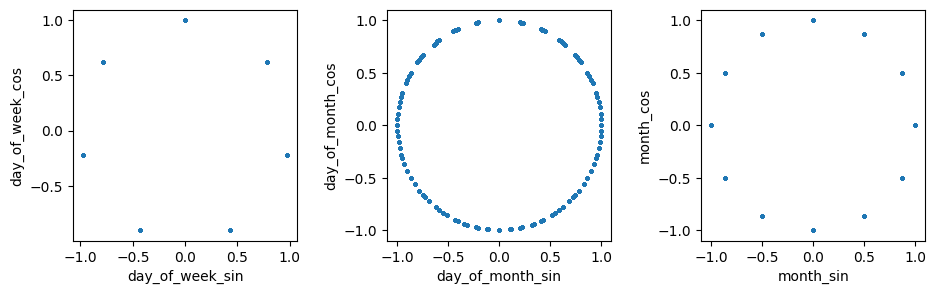

In [13]:
# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3, ))

# Create scatterplots for each feature
axes[0].scatter(df['day_of_week_sin'], df['day_of_week_cos'], s=3)
axes[0].set_xlabel('day_of_week_sin')
axes[0].set_ylabel('day_of_week_cos')

axes[1].scatter(df['day_of_month_sin'], df['day_of_month_cos'], s=3)
axes[1].set_xlabel('day_of_month_sin')
axes[1].set_ylabel('day_of_month_cos')

axes[2].scatter(df['month_sin'], df['month_cos'], s=3)
axes[2].set_xlabel('month_sin')
axes[2].set_ylabel('month_cos')

# Show the plots
fig.subplots_adjust(wspace=0.4)
plt.show()

In [12]:
df.scheme.value_counts()

scheme
ATM withdrawal    322576
Wire              208193
Interest          131228
Cash in           114020
Card                6349
Name: count, dtype: int64

## DataLoader

Here, we need to prepare the data for loading. First, we also need to process the references, so that the batching is faster afterwards.

In [16]:
def convert_time_features(df):
    # Convert the date column to datetime objects
    dates = pd.to_datetime(df['datetime'])

    # Calculate the angles for each time feature
    day_of_week_angle = 2 * np.pi * dates.dt.dayofweek / 7
    day_of_month_angle = 2 * np.pi * (dates.dt.day - 1) / (dates.dt.daysinmonth - 1)
    month_angle = 2 * np.pi * (dates.dt.month - 1) / 12

    # Transform the angles into continuous features using sine and cosine functions
    day_of_week = np.column_stack((np.sin(day_of_week_angle), np.cos(day_of_week_angle)))
    day_of_month = np.column_stack((np.sin(day_of_month_angle), np.cos(day_of_month_angle)))
    month = np.column_stack((np.sin(month_angle), np.cos(month_angle)))

    # Combine the continuous features into a single numpy array
    time_features = np.hstack((day_of_week, day_of_month, month))

    return time_features

In [17]:
# the feature names dictionary
# keys are indexes

feature_names_dictionary = {
    0: 'weekday_sin',
    1: 'weekday_cos',
    2: 'monthday_sin',
    3: 'monthday_cos',
    4: 'month_sin',
    5: 'month_cos',
    6: 'log_amount',
    7: 'direction',
    8: 'ATM withdrawal',
    9: 'Card',
    10: 'Cash in',
    11: 'Interest',
    12: 'Wire',
}

In [18]:
def fit_onehot_encoder(grouped_df):
    encoder = OneHotEncoder(sparse_output=False)
    v = np.array(grouped_df.obj.scheme).reshape(-1, 1)
    encoder.fit(v)
    return encoder

onehot_encoder = fit_onehot_encoder(grouped_df)
MX_length = 500

class TransactionDataset(Dataset):
    
    def __init__(self, grouped_df, onehot_encoder, ids=None, *, min_length=50, max_length=500):
        self.ids = ids if ids is not None else list(grouped_df.groups)
        self.gdf = grouped_df
        self.encoder = onehot_encoder
        self.min_length = min_length
        self.max_length = max_length
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            # Get the start, stop, and step from the slice
            if key.step is not None:
                return [self._get_item(i) for i in range(key.start, key.stop, key.step)]
            else:
                return [self._get_item(i) for i in range(key.start, key.stop)]
        elif isinstance(key, int):
            return self._get_item(key)
        
    def _get_item(self, idx):
        x = self._get_array(idx)
        # return self.get_fixed_history(x)
        return self.get_variable_history(x)
        
    def get_fixed_history(self, transaction_sequence):
        start_ix = random.randint(0, transaction_sequence.shape[0] - self.min_length - 1)
        
        return (
            transaction_sequence[start_ix:start_ix + self.min_length],
            transaction_sequence[start_ix+1:start_ix + self.min_length+1]
        )

    def get_variable_history(self, transaction_sequence):
        max_len = min(transaction_sequence.shape[0], self.max_length)
        seq_length = random.randint(self.min_length, max_len - 1)
        start_ix = random.randint(0, max_len - seq_length - 1)
        
        return (
            transaction_sequence[start_ix:start_ix + seq_length],
            transaction_sequence[start_ix+1:start_ix + seq_length+1]
        )
    
    def get_consequent_history_of_customer(self, idx: int, seq_length: int, max_history_length=30):
        transaction_sequence = self._get_array(idx)
        max_length = min(transaction_sequence.shape[0] - seq_length, max_history_length)
        
        histories_input = []
        histories_target = []
        
        for start_ix in range(max_length):
            input_seq = transaction_sequence[start_ix:start_ix + seq_length]
            target_seq = transaction_sequence[start_ix+1:start_ix + seq_length+1]
            histories_input.append(input_seq)
            histories_target.append(target_seq)
            
        return histories_input, histories_target
        
    def _get_array(self, idx):
        g = self.get_group(idx)
        t = self.get_time_features(g)         # continuous       (seq_length, 6)
        a = self.get_amount(g)                # continuous       (seq_length, 1)
        binary, onehot = self.get_onehot(g)   # binary / onehot  (seq_length, 1) and (seq_length, 5)
                                              # total:           13
        
        continuous = np.concatenate((t, a), axis=1)
        continuous = torch.from_numpy(np.array(continuous, dtype=np.float32))
        binary = torch.from_numpy(np.array(binary, dtype=np.float32))
        onehot = torch.from_numpy(np.array(onehot, dtype=np.float32))
        
        train = (continuous, binary, onehot)
        return torch.cat(train, dim=-1)
    
    def get_customer_len(self, idx):
        g = self.get_group(idx)
        return len(g)
    
    def get_group(self, ix):
        return self.gdf.get_group(self.ids[ix])
    
    def get_time_features(self, g):
        """Returns an array of shape (6, seq_length) with sin/cos repr. of weekday, monthday, month."""
        return convert_time_features(g)
    
    def get_amount(self, g):
        """Returns the logarithmized amount."""
        return np.log(1 + np.array(g.amount)).reshape(-1,1)
    
    def get_onehot(self, g):
        direction = g.direction == 'inbound'
        binary = np.array(direction, dtype=float)
        
        onehot = self.encoder.transform(np.array(g['scheme']).reshape(-1, 1))
        return binary.reshape(-1,1), onehot
    
    @property
    def continuous_length(self):
        x = self.get_time_features(self.get_group(1))
        y = self.get_amount(self.get_group(1))
        return x.shape[-1] + y.shape[-1]
    
    @property
    def binary_length(self):
        x = self.get_onehot(self.get_group(1))[0]
        return x.shape[-1]
    
    @property
    def onehot_length(self):
        x = self.get_onehot(self.get_group(1))[1]
        return x.shape[-1]
    
    @property
    def feature_length(self):
        x = self._get_array(1)
        return x.shape[1]
    
    @property
    def type_lengths(self):
        return [self.continuous_length, self.binary_length, self.onehot_length]
    
    def print_lengths(self):
        print('Continuous length:', self.continuous_length)
        print('Binary length:    ', self.binary_length)
        print('Onehot length:    ', self.onehot_length)
        print('Total feature length:', self.feature_length)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# if loading and already saved model and parameters...
import cloudpickle

with open('gpt_model.cpkl', 'rb') as f:
    saving = cloudpickle.load(f)

model = saving['model']
optimizer = saving['optimizer']
scheduler = saving['scheduler']
ids = saving['ids']
train_ix = saving['train_ix']
test_ix = saving['test_ix']

In [21]:
dataset = TransactionDataset(grouped_df, onehot_encoder, ids, min_length=30, max_length=250)
# train_ix, test_ix = train_test_split(range(len(dataset)), train_size=0.8)
dataset.print_lengths()

Continuous length: 7
Binary length:     1
Onehot length:     5
Total feature length: 13


In [22]:
def create_minibatch(dataset, ixs, batch_size, n_batches, max_sequence_length=200):
    
    for _ in range(n_batches):
        # Randomly sample starting indices for the sequences
        start_indices = random.sample(ixs, batch_size)

        # Initialize input and target tensors with zero-padding
        inputs = torch.zeros(batch_size, max_sequence_length, dataset.feature_length)
        targets = torch.zeros(batch_size, max_sequence_length, dataset.feature_length)
        # padding_masks = torch.ones(batch_size, max_sequence_length, dtype=bool)
        padding_masks = torch.ones(batch_size, max_sequence_length, dtype=torch.float32)

        # Fill input and target tensors with data from the dataset
        for i, start_idx in enumerate(start_indices):
            input_data, target_data = dataset[start_idx]
            
            seq_length = input_data.size(0)
            inputs[i, :seq_length, :] = input_data
            targets[i, :seq_length, :] = target_data

            # Fill the masks with 1 for non-padded elements
            # padding_masks[i, :seq_length] = False
            padding_masks[i, :seq_length] = 0
        
        # Create target attention mask
        # causality_mask = torch.triu(torch.ones(max_sequence_length, max_sequence_length), diagonal=1).bool()
        
        # yield inputs, targets, input_masks, target_masks
        yield inputs, targets, padding_masks#, causality_mask

In [23]:
batch_size = 32
n_batches = 10

In [24]:
minibatch_generator = create_minibatch(dataset, train_ix, batch_size, n_batches, max_sequence_length=250)

In [25]:
for input_batch, target_batch, padding_mask in minibatch_generator:
    # Perform your model training or evaluation here
    print(input_batch.shape)
    print(target_batch.shape)
    print(padding_mask.shape)
    break

torch.Size([32, 250, 13])
torch.Size([32, 250, 13])
torch.Size([32, 250])


In [26]:
padding_mask.shape

torch.Size([32, 250])

<Axes: >

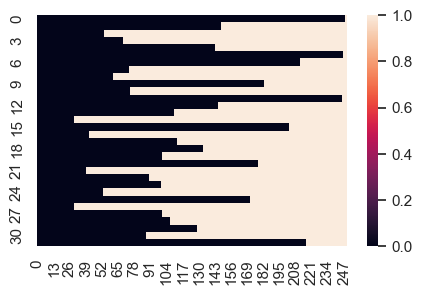

In [27]:
plotsize(5,3)
# plt.subplot(1,2,1)
sns.heatmap(padding_mask)

# plt.subplot(1,2,2)
# sns.heatmap(causality_mask)

In [28]:
padding_mask

tensor([[0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [29]:
1 - padding_mask

tensor([[1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

# Model

## Model preparation

In [30]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [31]:
# model without variance

class TransformerModel(nn.Module):
    def __init__(self, dataset, num_features, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(num_features, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        m = self.generate_square_subsequent_mask()
        self.mask = m
        
        self.transformer_layers = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerDecoder(self.transformer_layers, num_layers)

        self.mean = nn.Linear(d_model, dataset.continuous_length)
        self.binary_model = nn.Linear(d_model, dataset.binary_length)
        self.onehot_model = nn.Linear(d_model, dataset.onehot_length)
        
    def generate_square_subsequent_mask(self, size=200): # Generate mask covering the top right triangle of a matrix
        mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1).to(device)
        return mask.to(device)
        
    def forward(self, src, padding_mask=None, causality_mask=None):
    
        # process through the model
        src = self.embedding(src)
        src = self.positional_encoding(src)
        mask_size = src.shape[1]
        # print(mask_size)
        m = self.generate_square_subsequent_mask(mask_size)
        x = self.transformer(
            src, src,                                                                 # target and memory are the same
            tgt_mask=m, memory_mask=m,                                                # triangular masks so that we do not attend to the future tokens
            tgt_key_padding_mask=padding_mask, memory_key_padding_mask=padding_mask,  # padding mask, so that we are not training on padded parts of the sequences
        )
        
        # process the outpus
        c_mean = self.mean(x)
        b = torch.sigmoid(self.binary_model(x))
        oh = self.onehot_model(x) # should be raw logits
        
        return c_mean, b, oh

In [78]:
model.generate_square_subsequent_mask()

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')

In [137]:
# # model with variance
 
# class TransformerModel(nn.Module):
#     def __init__(self, dataset, num_features, d_model, nhead, num_layers, dim_feedforward, dropout):
#         super(TransformerModel, self).__init__()
        
#         self.embedding = nn.Linear(num_features, d_model)
#         self.positional_encoding = PositionalEncoding(d_model)
#         m = self.generate_square_subsequent_mask()
#         self.mask = m
        
#         self.transformer_layers = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, norm_first=True)
#         self.transformer = nn.TransformerDecoder(self.transformer_layers, num_layers)

#         self.mean = nn.Linear(d_model, dataset.continuous_length)
#         self.var = nn.Sequential(
#             nn.Linear(d_model, dataset.continuous_length),
#             nn.Softplus(),
#         )
#         self.binary_model = nn.Linear(d_model, dataset.binary_length)
#         self.onehot_model = nn.Linear(d_model, dataset.onehot_length)
        
#     def generate_square_subsequent_mask(self, size=200): # Generate mask covering the top right triangle of a matrix
#         mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1).to(device)
#         return mask.to(device)
        
#     def forward(self, src, padding_mask=None, causality_mask=None):
    
#         # process through the model
#         src = self.embedding(src)
#         src = self.positional_encoding(src)
#         mask_size = src.shape[1]
#         # print(mask_size)
#         m = self.generate_square_subsequent_mask(mask_size)
#         x = self.transformer(
#             src, src,                                                                 # target and memory are the same
#             tgt_mask=m, memory_mask=m,                                                # triangular masks so that we do not attend to the future tokens
#             tgt_key_padding_mask=padding_mask, memory_key_padding_mask=padding_mask,  # padding mask, so that we are not training on padded parts of the sequences
#         )
        
#         # process the outpus
#         c_mean = self.mean(x)
#         c_var = self.var(x)
#         b = torch.sigmoid(self.binary_model(x))
#         oh = self.onehot_model(x) # should be raw logits
        
#         return c_mean, c_var, b, oh

In [32]:
torch.cuda.is_available()

False

In [33]:
torch.backends.mps.is_built()

True

In [34]:
input_dim = dataset.feature_length
d_model = 512 # 512
nhead = 8               # 8
num_layers = 6  # 6
dim_feedforward = 2048   # 2048
dropout = 0.1
device = torch.device('mps')

# model = TransformerModel(dataset, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout)
model

TransformerModel(
  (embedding): Linear(in_features=13, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_layers): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (transfor

In [35]:
model.generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0')

<Axes: >

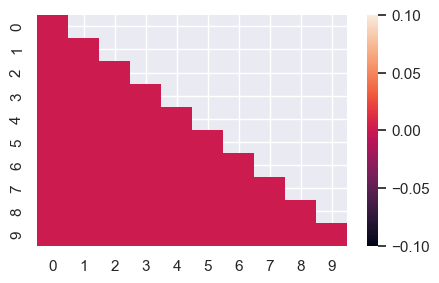

In [36]:
sns.heatmap(model.generate_square_subsequent_mask(10).cpu())

In [79]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model.to(device)

with torch.no_grad():
    # c_mean, c_var, b, o = model(input_batch.to(device), padding_mask.to(device))
    c_mean, b, o = model(input_batch.to(device), padding_mask.to(device))

In [40]:
c_mean[1]

tensor([[ 2.9254e-01,  2.2768e-01,  5.6413e-02,  ...,  5.3629e-01,
         -8.1863e-01,  7.2230e+00],
        [-1.0365e-01,  2.1819e-01, -4.8428e-01,  ...,  3.4013e-01,
         -8.7262e-01,  8.8042e+00],
        [-2.8832e-03,  1.3972e-01, -5.1712e-01,  ...,  6.5917e-01,
         -8.5211e-01,  7.8094e+00],
        ...,
        [-6.6755e-02,  2.8305e-01, -2.2702e-01,  ...,  6.1786e-02,
         -1.4059e-01,  4.3989e+00],
        [ 8.4621e-02,  4.4146e-01, -3.1330e-01,  ..., -1.0586e-01,
         -1.6472e-01,  4.8379e+00],
        [-2.3764e-02, -4.3412e-02, -4.3550e-01,  ...,  3.3783e-02,
          1.9610e-02,  4.4828e+00]], device='mps:0')

In [41]:
# parameters
label_smoothing = 0.1
type_lengths = dataset.type_lengths

def gaussian_log_likelihood(y_pred, log_var, y_true, mask):
    """
    Computes the Gaussian log-likelihood loss with padding mask.

    Parameters:
    y_pred (torch.Tensor): Predicted values, typically the mean of the Gaussian distribution.
    y_true (torch.Tensor): Ground truth values.
    log_var (torch.Tensor): Logarithm of the variance of the Gaussian distribution.
    mask (torch.Tensor): Padding mask with the same shape as y_true and y_pred.

    Returns:
    torch.Tensor: Gaussian log-likelihood loss.
    """
    mse = F.mse_loss(y_pred, y_true, reduction='none')
    
    # Apply the mask to the mse and log_var tensors
    m = mask.unsqueeze(-1).expand_as(y_pred)
    masked_mse = mse * m
    masked_log_var = log_var * m

    loss = 0.5 * (masked_log_var + masked_mse / torch.exp(masked_log_var))
    
    # Calculate the mean loss considering only the non-padded elements
    loss = loss.sum() / m.sum()
    return loss

def mse_loss(y_pred, y_true, mask):
    """
    Computes the MSE loss with padding mask.

    Parameters:
    y_pred (torch.Tensor): Predicted values.
    y_true (torch.Tensor): Ground truth values.
    mask (torch.Tensor): Padding mask with the same shape as y_true and y_pred.

    Returns:
    torch.Tensor: Masked MSE loss.
    """
    mse = F.mse_loss(y_pred, y_true, reduction='none')
    
    # Apply the mask to the mse and log_var tensors
    m = mask.unsqueeze(-1).expand_as(y_pred)
    masked_mse = mse * m
    
    # Calculate the mean loss considering only the non-padded elements
    loss = masked_mse.sum() / m.sum()
    return loss

def binary_loss(y_pred, y_true, mask, label_smoothing=0.1):
    m = mask.unsqueeze(-1).expand_as(y_pred)
    y_pred_masked = y_pred * m
    y_true_masked = (y_true * (1 - label_smoothing * 2) + label_smoothing) * m
    
    binary_crossentropy = nn.BCELoss(reduction='sum')(y_pred_masked, y_true_masked) / m.sum()
    return binary_crossentropy

ce_loss = nn.CrossEntropyLoss(reduction='none', label_smoothing=label_smoothing)

def onehot_loss(y_pred, y_true, mask, label_smoothing=0.1):
    onehot_indices = torch.argmax(y_true, dim=-1) * mask.long()
    onehot_crossentropy = (ce_loss(y_pred.permute(0,2,1), onehot_indices) * mask).sum() / mask.sum()
    return onehot_crossentropy

# def compute_masked_losses(mean, var, binary, onehot, target, mask):
#     c, b, o = target.split(dataset.type_lengths, dim=-1)
#     loglikelihood = gaussian_log_likelihood(mean, var, c, mask)
#     b_loss = binary_loss(binary, b, mask)
#     oh_loss = onehot_loss(onehot, o, mask)
    
#     return loglikelihood + b_loss + oh_loss

def compute_masked_losses(mean, binary, onehot, target, mask):
    c, b, o = target.split(dataset.type_lengths, dim=-1)
    m_loss = mse_loss(mean, c, mask)
    b_loss = binary_loss(binary, b, mask)
    oh_loss = onehot_loss(onehot, o, mask)
    
    return m_loss + b_loss + oh_loss

def append_to_masked_losses(mean, var, binary, onehot, target, mask):
    model.eval()
    c, b, o = target.split(dataset.type_lengths, dim=-1)
    loglikelihood = gaussian_log_likelihood(mean, var, c, mask)
    b_loss = binary_loss(binary, b, mask)
    oh_loss = onehot_loss(onehot, o, mask)
    
    return loglikelihood, b_loss, oh_loss

In [42]:
with torch.no_grad():
    # c_mean, c_var, b, o = model(input_batch.to(device), padding_mask.to(device))
    c_mean, b, o = model(input_batch.to(device), padding_mask.to(device))

In [43]:
# compute_masked_losses(c_mean, c_var, b, o, target_batch.to(device), padding_mask.to(device))
compute_masked_losses(c_mean, b, o, target_batch.to(device), padding_mask.to(device))

tensor(5.3139, device='mps:0')

In [172]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Set the learning rate and weight decay for the Adam optimizer
learning_rate = 1e-4
weight_decay = 1e-7

# Set the total number of training epochs and the number of epochs for the learning rate scheduler
total_epochs = 100
scheduler_epochs = 50

# Initialize the optimizer with the model parameters, learning rate, and weight decay
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Initialize the learning rate scheduler
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_epochs, eta_min=0, last_epoch=-1)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=scheduler_epochs, T_mult=1, eta_min=0.000001)

In [44]:
scheduler.get_last_lr()

[5.6703995061433075e-05]

In [48]:
batch_losses = []

In [367]:
# saving = {
#     'model': model,
#     'optimizer': optimizer,
#     'scheduler': scheduler,
#     'ids': ids,
#     'train_ix': train_ix,
#     'test_ix': test_ix,
# }

In [368]:
# with open('gpt_saved.cpkl', 'wb') as f:
#     cloudpickle.dump(saving, f)

In [76]:
# 5min 19s
device = torch.device('cpu')

In [197]:
%%time

# Set the number of epochs, batches per epoch, and batch size
num_epochs = 20
n_batches = 30
batch_size = 32
print_every = 10

# Loop over the total number of epochs
for epoch in range(num_epochs):
    model.train()
    # Initialize the minibatch generator
    minibatch_generator = create_minibatch(dataset, train_ix, batch_size, n_batches, max_sequence_length=250)

    # Initialize the epoch loss
    epoch_loss = 0.0

    # Loop over the batches in the minibatch generator
    for i, (inputs, targets, padding_mask) in enumerate(minibatch_generator):
        # Move inputs and targets to the appropriate device
        inputs = inputs.to(device)
        targets = targets.to(device)
        padding_mask = padding_mask.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        # c_mean, c_var, b, o = model(inputs, padding_mask)
        c_mean, b, o = model(inputs, padding_mask)

        # Compute the losses
        # loss = compute_masked_losses(c_mean, c_var, b, o, targets, 1 - padding_mask)
        loss = compute_masked_losses(c_mean, b, o, targets, 1 - padding_mask)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the epoch loss
        epoch_loss += loss.item()
        batch_losses.append(epoch_loss / (i+1))

        # Print the loss after every `print_every` batches
        if (i + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{n_batches}], Loss: {epoch_loss / (i+1):.4f}")

    # Adjust the learning rate using the scheduler
    scheduler.step()

    # Print the epoch loss
    print(f'Last learning rate: {scheduler.get_last_lr()}')
    # binary_accuracy_test(100)


Epoch [1/20], Batch [10/30], Loss: 1.2879
Epoch [1/20], Batch [20/30], Loss: 1.2846
Epoch [1/20], Batch [30/30], Loss: 1.2752
Last learning rate: [1.0976769428005578e-06]
Epoch [2/20], Batch [10/30], Loss: 1.2889
Epoch [2/20], Batch [20/30], Loss: 1.2981
Epoch [2/20], Batch [30/30], Loss: 1.2940
Last learning rate: [0.0001]
Epoch [3/20], Batch [10/30], Loss: 1.2836
Epoch [3/20], Batch [20/30], Loss: 1.3039
Epoch [3/20], Batch [30/30], Loss: 1.3180
Last learning rate: [9.990232305719945e-05]
Epoch [4/20], Batch [10/30], Loss: 1.3566
Epoch [4/20], Batch [20/30], Loss: 1.3478
Epoch [4/20], Batch [30/30], Loss: 1.3437
Last learning rate: [9.960967771506667e-05]
Epoch [5/20], Batch [10/30], Loss: 1.3393
Epoch [5/20], Batch [20/30], Loss: 1.3290
Epoch [5/20], Batch [30/30], Loss: 1.3313
Last learning rate: [9.91232189110701e-05]
Epoch [6/20], Batch [10/30], Loss: 1.3232
Epoch [6/20], Batch [20/30], Loss: 1.3274
Epoch [6/20], Batch [30/30], Loss: 1.3265
Last learning rate: [9.844486647586725e

In [179]:
scheduler.get_last_lr()

[1.3903222849333507e-06]

In [180]:
min(batch_losses)

1.208016037940979

11250


<Axes: >

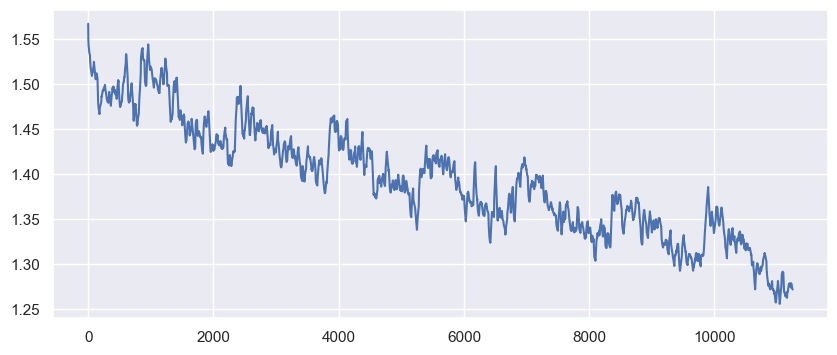

In [181]:
plotsize(10,4)
print(len(batch_losses))
sns.lineplot(moving_average(batch_losses, 30))

## Results

Visualization of attention, test samples etc.

In [98]:
d_small = TransactionDataset(grouped_df, onehot_encoder, ids, min_length=199, max_length=200)

In [54]:
minibatch_generator = create_minibatch(d_small, test_ix, 20, 1, max_sequence_length=200)
for input_test, target_test, padding_test in minibatch_generator:
    # Perform your model training or evaluation here
    print(input_test.shape)
    print(target_test.shape)
    print(padding_test.shape)
    break

torch.Size([20, 200, 13])
torch.Size([20, 200, 13])
torch.Size([20, 200])


In [ ]:
with open(f'saved_models/test_batch.cpkl', 'wb') as f:
    cloudpickle.dump([input_test, target_test, padding_test], f)

In [200]:
model_copy = copy.deepcopy(model)

In [201]:
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []

def patch_attention(m):
    forward_orig = m.forward

    def wrap(*args, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False

        return forward_orig(*args, **kwargs)

    m.forward = wrap


model_copy.eval()
save_output = SaveOutput()
patch_attention(model_copy.transformer.layers[-1].self_attn)
hook_handle = model_copy.transformer.layers[-1].self_attn.register_forward_hook(save_output)

for module in model_copy.transformer.modules():
    if isinstance(module, nn.MultiheadAttention):
        patch_attention(module)
        handle = module.register_forward_hook(save_output)
        # handle.remove()
        
# hook_handle.remove()
        
with torch.no_grad():
    out = model_copy(input_test.to(device), padding_test.to(device))

In [202]:
print('Number of outputs:', len(save_output.outputs))
print('Shape of output:', save_output.outputs[0].shape)

Number of outputs: 13
Shape of output: torch.Size([20, 8, 200, 200])


In [203]:
save_output.outputs[0][1, 0, :10, :9]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7589e-01, 4.2411e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0862e-01, 1.4976e-01, 6.4162e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0525e-01, 2.1348e-01, 5.8109e-01, 1.7067e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9894e-01, 1.4789e-01, 5.1794e-01, 2.9019e-04, 1.3494e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9850e-01, 1.2125e-01, 5.6157e-01, 6.0972e-05, 1.1860e-01, 6.6488e-06,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.2857e-01, 1.7949e-01, 4.7624e-01, 2.1213e-04, 1.1456e-01, 2.3093e-05,
         9.0759e-04, 0.0000e+00, 0.0000e+00],
        [1.9578e-01, 1.3039e-01, 4.0109e-01, 3.7539e-04, 1.0995e-01, 3.5981e-05,
         1.7567e-03, 1.6062e-0

In [204]:
save_output.outputs[0][1, 0, :10, :9]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7589e-01, 4.2411e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0862e-01, 1.4976e-01, 6.4162e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0525e-01, 2.1348e-01, 5.8109e-01, 1.7067e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9894e-01, 1.4789e-01, 5.1794e-01, 2.9019e-04, 1.3494e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9850e-01, 1.2125e-01, 5.6157e-01, 6.0972e-05, 1.1860e-01, 6.6488e-06,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.2857e-01, 1.7949e-01, 4.7624e-01, 2.1213e-04, 1.1456e-01, 2.3093e-05,
         9.0759e-04, 0.0000e+00, 0.0000e+00],
        [1.9578e-01, 1.3039e-01, 4.0109e-01, 3.7539e-04, 1.0995e-01, 3.5981e-05,
         1.7567e-03, 1.6062e-0

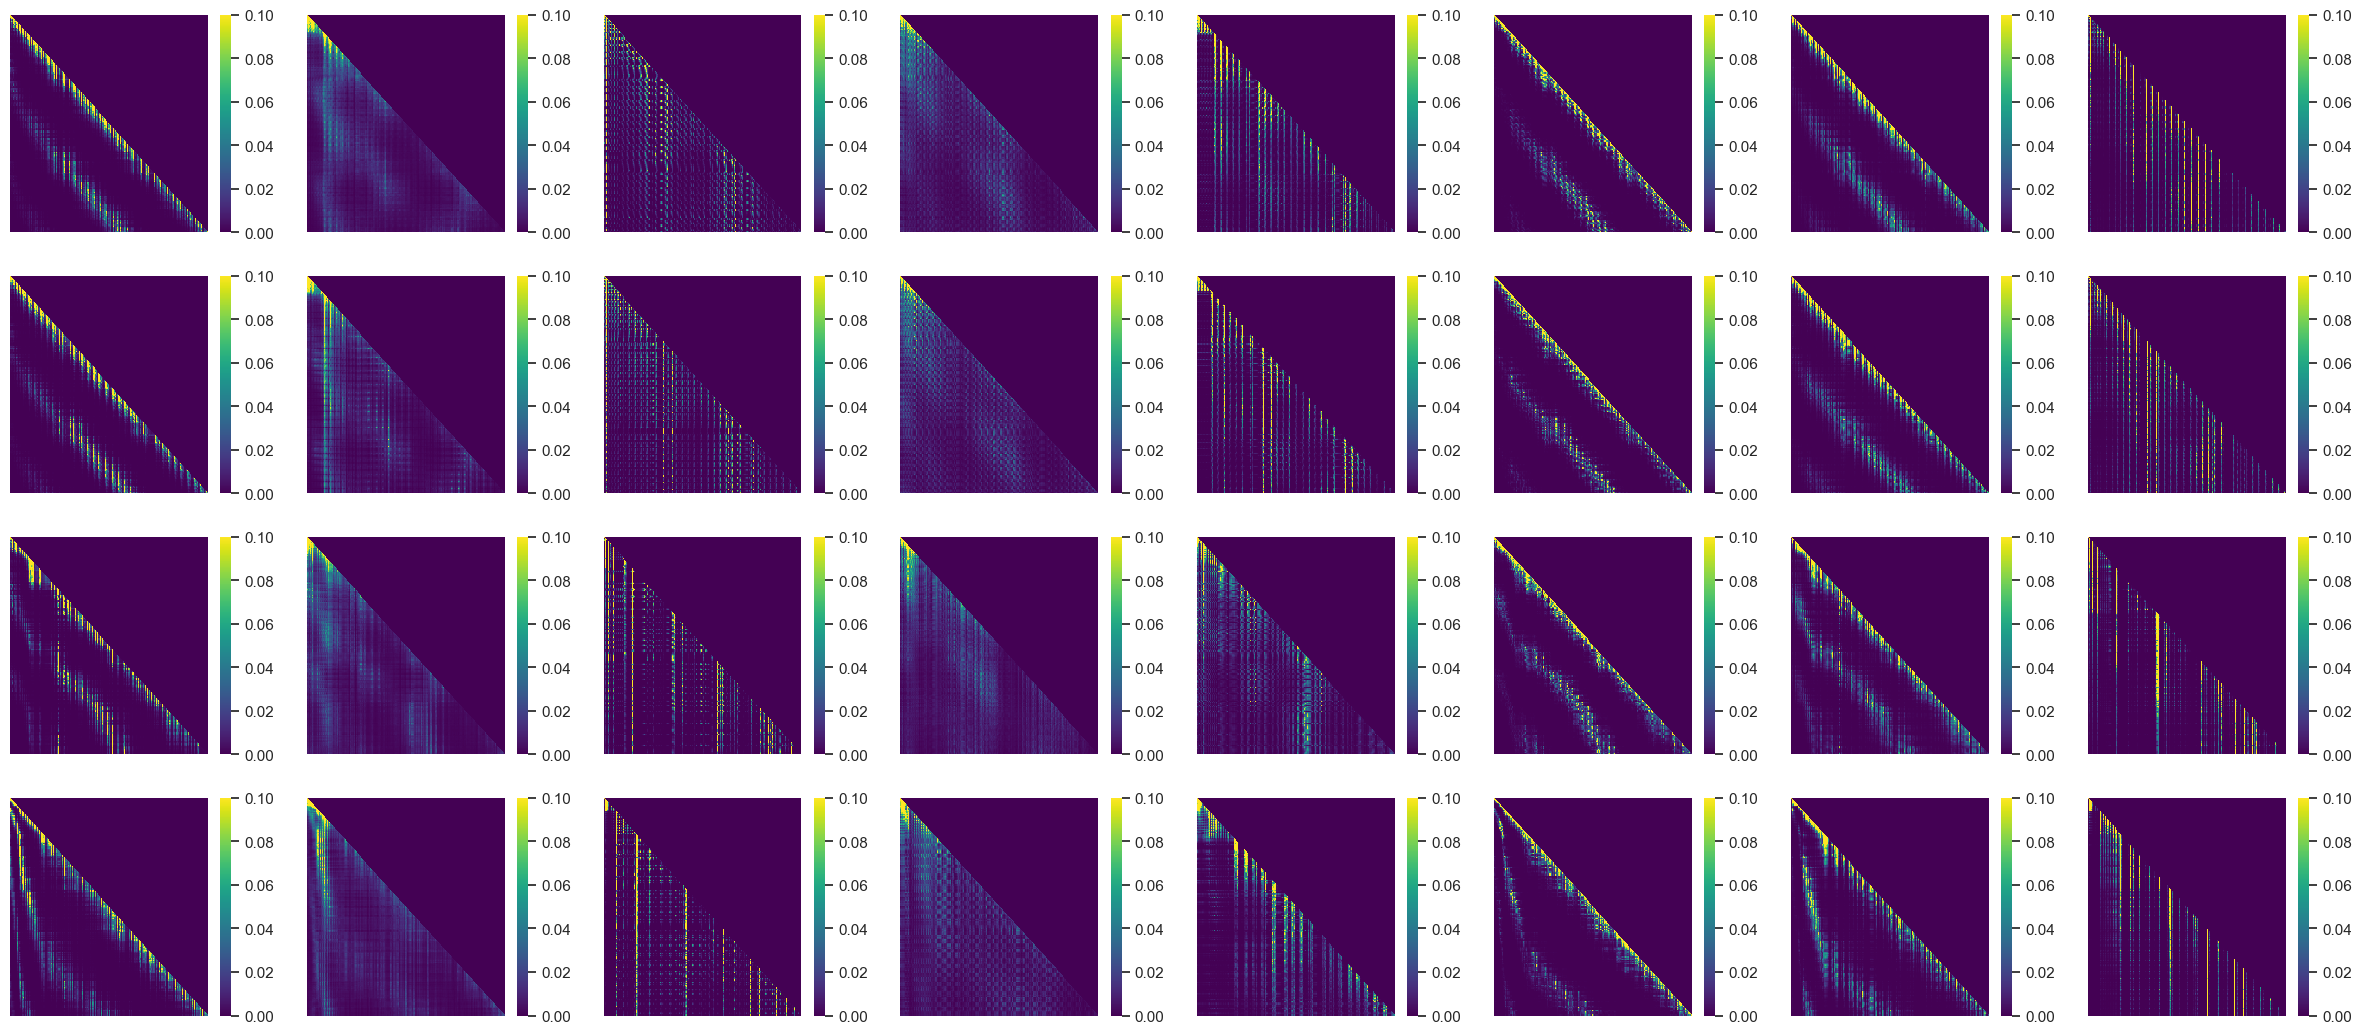

In [205]:
plotsize(30,13)

mb = 4
for batch_ix in range(mb):
    # batch_ix = 5
    for head_ix in range(8):
        plt.subplot(mb, 8, head_ix + batch_ix * 8 + 1)
        max_size = np.sum((padding_test[batch_ix] == 0).numpy())
        tmp = save_output.outputs[2][batch_ix, head_ix, :, :]
        tmp = tmp[:max_size, :max_size]
        tmp = tmp.clamp(max=0.1)
        # print(max_size)
        ax = sns.heatmap(tmp.cpu(), cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

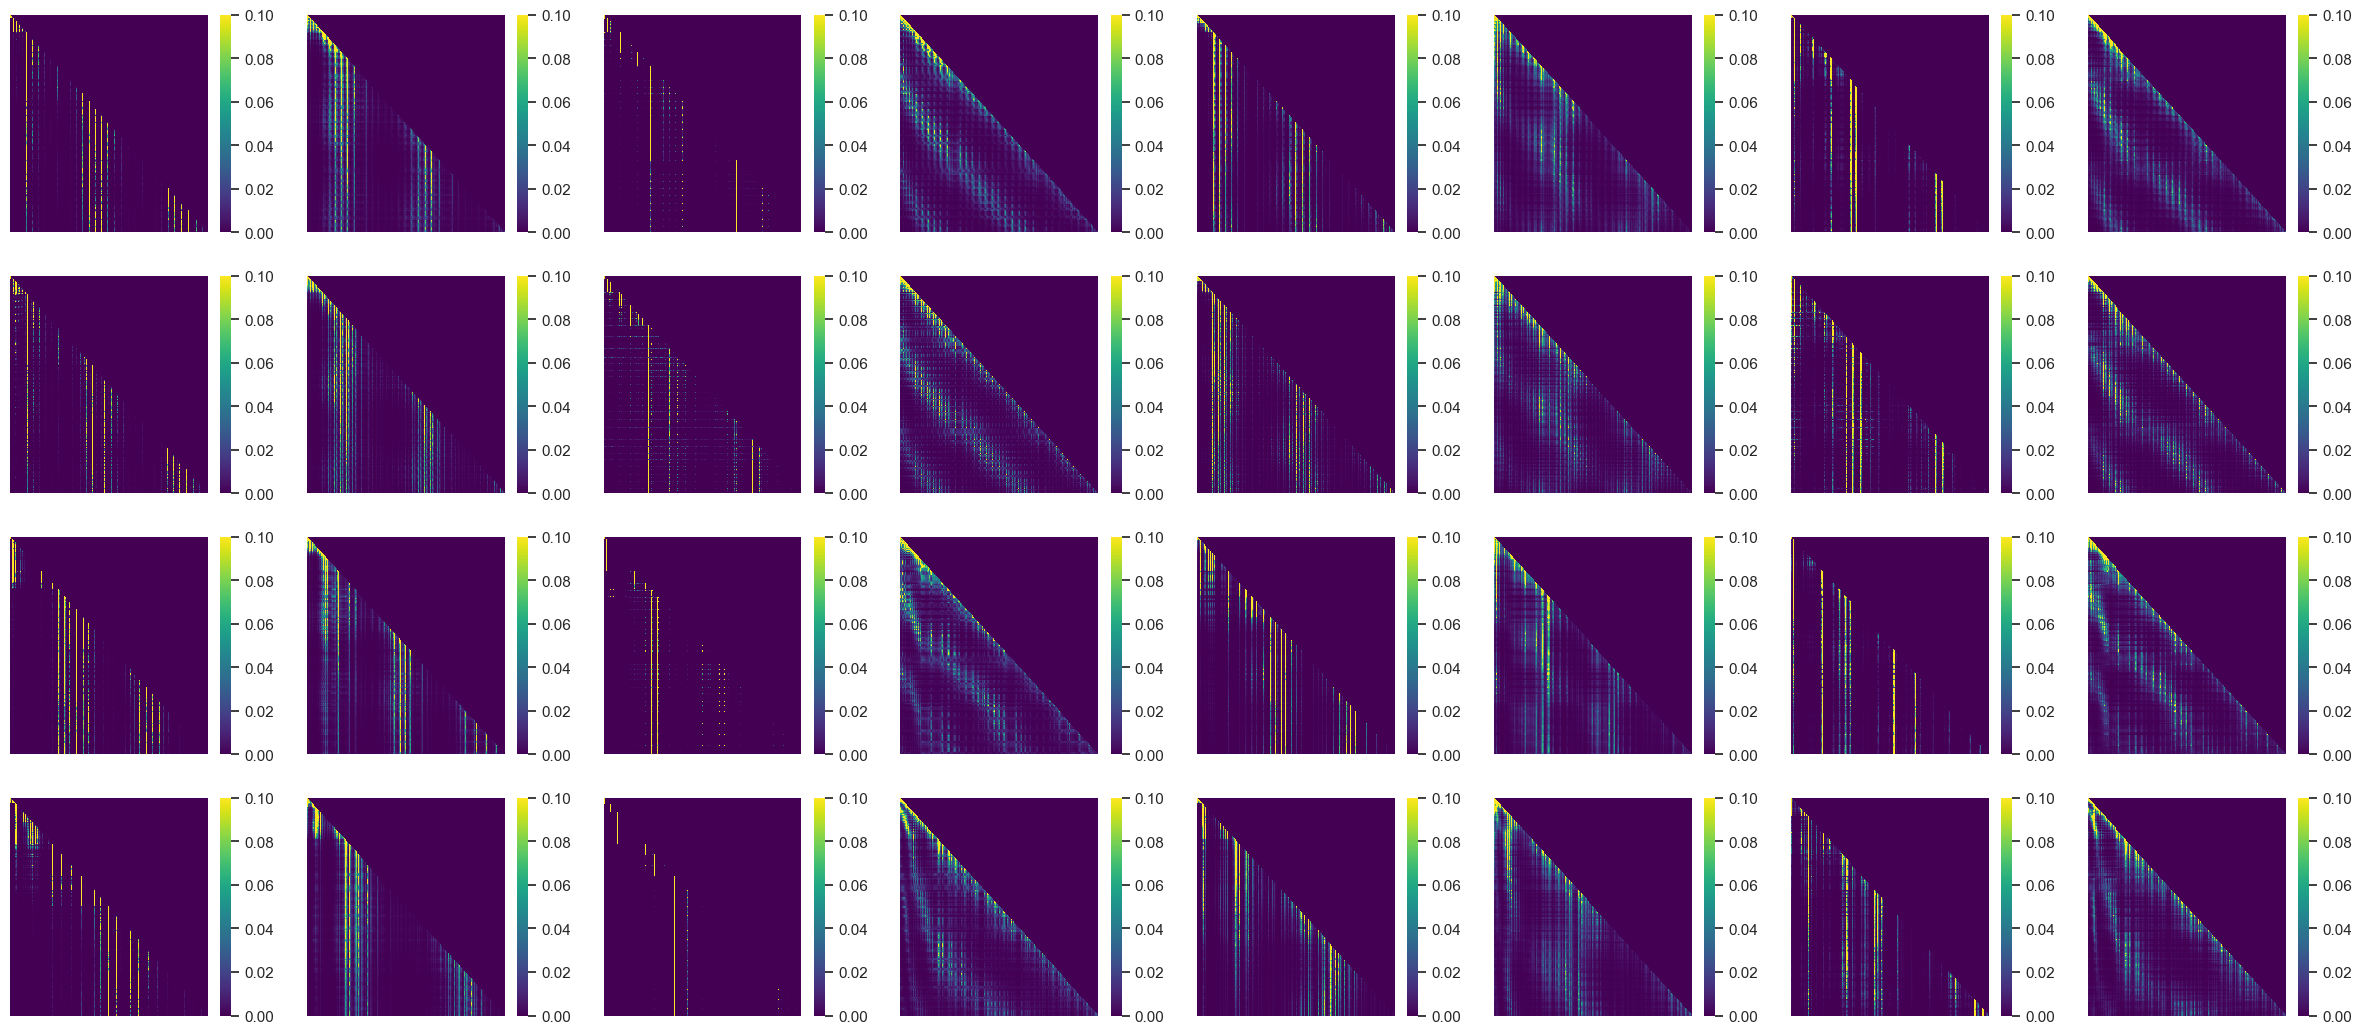

In [206]:
plotsize(30,13)

mb = 4
for batch_ix in range(mb):
    # batch_ix = 5
    for head_ix in range(8):
        plt.subplot(mb , 8, head_ix + batch_ix * 8 + 1)
        max_size = np.sum((padding_test[batch_ix] == 0).numpy())
        tmp = save_output.outputs[1][batch_ix, head_ix, :, :]
        tmp = tmp[:max_size, :max_size]
        tmp = tmp.clamp(max=0.1)
        # print(max_size)
        ax = sns.heatmap(tmp.cpu(), cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

In [207]:
if len(out) == 4:
    c_mean, c_var, b, o = out[0].cpu(), out[1].cpu(), out[2].cpu(), out[3].cpu()
else:
    c_mean, b, o = out[0].cpu(), out[1].cpu(), out[2].cpu()


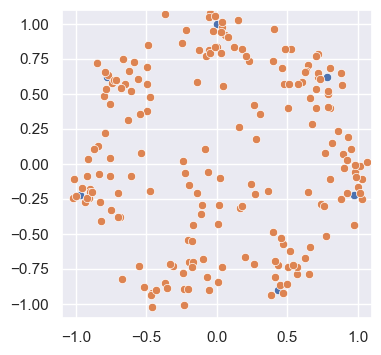

In [208]:
plotsize(4,4)
ix = 0
x_i = 0
y_i = 1
sns.scatterplot(
    x = input_test[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = input_test[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
sns.scatterplot(
    x = c_mean[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = c_mean[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.show()

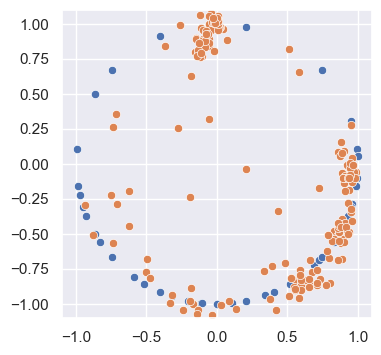

In [191]:
plotsize(4,4)
ix = 0
x_i = 2
y_i = 3
sns.scatterplot(
    x = input_test[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = input_test[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
sns.scatterplot(
    x = c_mean[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = c_mean[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.show()

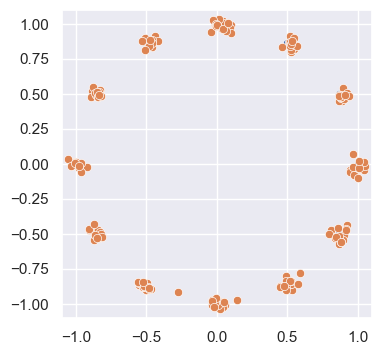

In [192]:
plotsize(4,4)
ix = 0
x_i = 4
y_i = 5
sns.scatterplot(
    x = input_test[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = input_test[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
sns.scatterplot(
    x = c_mean[ix, padding_test[0] == 0, :].numpy()[:, x_i],
    y = c_mean[ix, padding_test[0] == 0, :].numpy()[:, y_i],
)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.show()

In [190]:
feature_names_dictionary

{0: 'weekday_sin',
 1: 'weekday_cos',
 2: 'monthday_sin',
 3: 'monthday_cos',
 4: 'month_sin',
 5: 'month_cos',
 6: 'log_amount',
 7: 'direction',
 8: 'ATM withdrawal',
 9: 'Card',
 10: 'Cash in',
 11: 'Interest',
 12: 'Wire'}

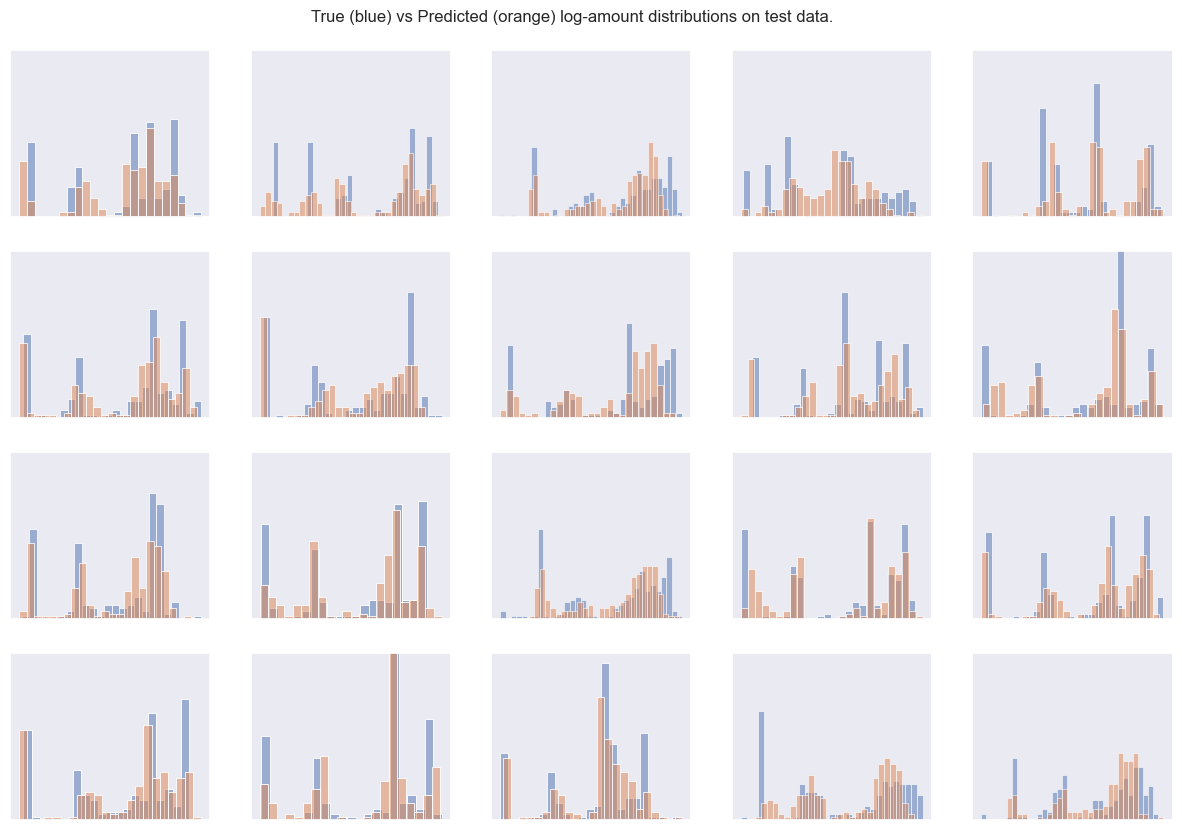

In [193]:
plotsize(15, 10)
for ix in range(20):
    plt.subplot(4,5,ix+1)
    sns.histplot(input_test[ix, padding_test[ix] == 0, :].numpy()[:, 6], label='true', binwidth=0.3, alpha=0.5, stat='density')
    sns.histplot(c_mean[ix, padding_test[ix] == 0, :].numpy()[:, 6], label='predicted', binwidth=0.3, alpha=0.5, stat='density')
    plt.ylabel('')
    plt.ylim(0,1)
    plt.xticks([])
    plt.yticks([])

plt.suptitle('True (blue) vs Predicted (orange) log-amount distributions on test data.', fontsize=12, y=0.92)
plt.show()

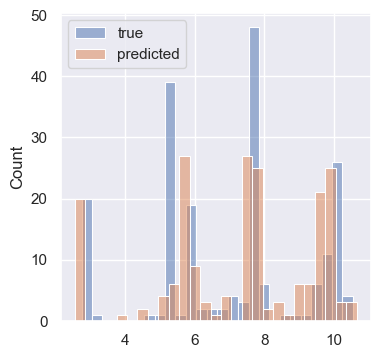

In [194]:
ix = random.sample(range(10), 1)[0]
plotsize(4,4)
sns.histplot(input_test[ix, padding_test[ix] == 0, :].numpy()[:, 6], label='true', binwidth=0.3, alpha=0.5)
sns.histplot(c_mean[ix, padding_test[ix] == 0, :].numpy()[:, 6], label='predicted', binwidth=0.3, alpha=0.5)
plt.legend()

<Axes: >

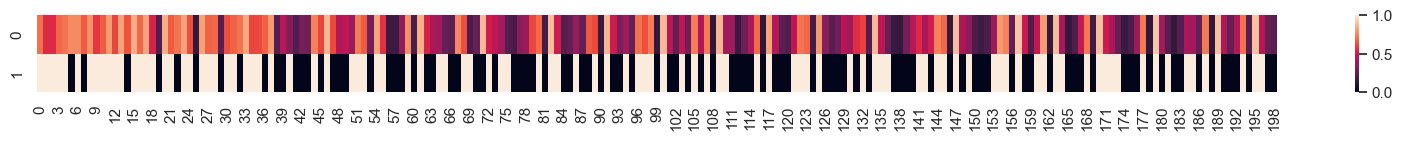

In [377]:
plotsize(20,1)
bpred = np.round(b[1, padding_test[1] == 0, :].detach().numpy(), 2).transpose()
btarget = target_test[1, padding_test[1] == 0, 7].numpy().reshape(1,-1)
np.vstack((bpred, btarget))
sns.heatmap(np.vstack((bpred, btarget)))

In [381]:
import cloudpickle

In [198]:
saving = {
    'model': model,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ids': ids,
    'train_ix': train_ix,
    'test_ix': test_ix,
}

In [199]:
with open('saved_models/gpt_model.cpkl', 'wb') as f:
    cloudpickle.dump(saving, f)

In [56]:
def find_closest_key(dictionary, target_vector):
    min_distance = float('inf')
    closest_key = None

    for key, value in dictionary.items():
        distance = np.linalg.norm(np.array(value) - np.array(target_vector))
        if distance < min_distance:
            min_distance = distance
            closest_key = key

    return closest_key

In [57]:
inv_log = lambda x: np.exp(x) - 1

In [58]:
binary_types = ['outbound', 'inbound']

In [59]:
def process_vector(vector, which=-1):
    c, b, oh = vector.split(type_lengths, dim=-1)
    c = c.numpy()[which]
    
    timediff_in_seconds = inv_log(c[0])
    weekday = find_closest_key(dataset.weekday_dict, c[5:7])
    day = find_closest_key(dataset.day_dict, c[7:9])
    month = find_closest_key(dataset.month_dict, c[9:11])
    amount = inv_log(c[11])
    decimal = c[12]
    
    b = np.array(np.round(b.numpy()[which]), dtype=int)
    pred_type = []
    for (i, bi) in enumerate(b):
        pred_type.append(binary_types[i, bi])
        
    oh = np.argmax((nn.Softmax(dim=-1)(oh[which,:]).numpy()))
    scheme = onehot_encoder.categories_[0][oh]
    
    return {
        'weekday': weekday,
        'day': day,
        'month': month,
        'amount': round(amount, 2),
        'direction': pred_type[0],
        'scheme': scheme
    }

In [64]:
def model_prediction(model, input_sequence):
    """
    Return predicted feature vector.
    """
    
    model.eval()
    if len(input_sequence.shape) < 3:
        input_sequence = input_sequence.unsqueeze(0)
        
    pred = model(input_sequence).squeeze(0).detach()
    return process_vector(pred)

In [65]:
cix = 5

In [66]:
history_sequences, target_sequences = dataset.get_consequent_history_of_customer(cix, 90, max_history_length=100)

In [67]:
df_tg = pd.DataFrame(process_vector(target_sequences[0]), index=['target'])
df_pred = pd.DataFrame(model_prediction(model, history_sequences[0]), index=['prediction'])
empty_df = pd.DataFrame({
        'timediff': '--------',
        'weekday': '-------',
        'day': '---',
        'month': '-----',
        'amount': '------',
        'direction': '---------',
        'initiator': '---------',
        'type': '----',
        'scheme': '-----'
}, index=['----------'])
dd = pd.concat(objs=[df_tg, df_pred, empty_df])

for i in range(1, 20):
    df_tg = pd.DataFrame(process_vector(target_sequences[i]), index=['target'])
    df_pred = pd.DataFrame(model_prediction(model, history_sequences[i]), index=['prediction'])
    dd = pd.concat(objs=[dd, df_tg, df_pred, empty_df])

RuntimeError: The shape of the 2D attn_mask is torch.Size([200, 200]), but should be (90, 90).

In [312]:
dd

,timediff,weekday,day,month,amount,direction,initiator,type,scheme
target,0.00,5,5,8,104.45,outbound,customer,Card,Purchase
prediction,"1,521.27",5,6,8,36.13,outbound,customer,Card,Purchase
----------,--------,-------,---,-----,------,---------,---------,----,-----
target,0.00,5,5,8,98.38,outbound,customer,Card,Purchase
prediction,258.45,5,6,8,55.75,outbound,customer,Card,Purchase
----------,--------,-------,---,-----,------,---------,---------,----,-----
target,0.00,5,5,8,160.54,outbound,customer,Card,Purchase
prediction,165.07,6,5,7,42.44,outbound,customer,Card,Purchase
----------,--------,-------,---,-----,------,---------,---------,----,-----
target,0.00,5,5,8,133.23,outbound,customer,Card,Purchase


In [ ]:
dataset.get_group(cix)[dataset.get_group(cix).datetime > datetime(2022, 8, 8)]

In [188]:
pd.DataFrame(process_vector(target_sequences[0]), index=['target'])

,timediff,weekday,day,month,amount,direction,initiator,type,scheme
target,"40,725.00",5,9,9,"3,204.00",outbound,customer,Sepa,SEPA Credit Transfer


In [161]:
df[['type', 'scheme']].value_counts()

type  scheme                      
Card  Purchase                        1582182
Sepa  SEPA Credit Transfer            1029760
      SEPA Direct Debit                349334
Card  ATM                               59400
Sepa  SEPA Instant Credit Transfer      19422
dtype: int64

In [216]:
target_sequence[-1:, :].shape

torch.Size([1, 148])

In [176]:
onehot_encoder.categories_[0][oh]

'Purchase'

In [87]:
model_prediction(model, input_sequence)

array([ 8.205084  ,  0.34444663, -0.28517565,  0.10555738, -0.67375344,
       -0.03581319, -0.94600874,  4.884484  ,  0.3548579 ,  0.11475439,
        0.8171159 ,  0.689193  , -0.84037584,  1.8702732 ,  1.0729219 ,
       -0.28041008, -4.3212304 ,  0.7102686 ,  5.823054  ,  1.5775989 ,
        1.0188296 ,  1.3829209 ,  1.4172543 ,  1.4490178 ,  1.4798009 ,
        1.317794  ,  1.0802876 ,  1.0341547 ,  1.1396434 ,  1.1299201 ,
        0.8863929 ,  1.3995337 ,  1.5728667 ,  1.5284276 ,  1.3655118 ,
        1.0384642 ,  1.3174831 ,  1.0357283 ,  1.4409927 ,  1.1930027 ,
        1.1742499 ,  1.1904817 ,  1.1152956 ,  0.9839222 ,  0.9941137 ,
        1.0242276 ,  1.0833237 ,  0.894042  ,  1.0189067 ,  0.95620996,
        1.0572833 ,  1.3090813 ,  0.8689999 ,  0.86233467,  0.92138886,
        1.030651  ,  1.4752346 ,  1.0108483 ,  1.3099594 ,  1.1622041 ,
        1.1829    ,  0.92862266,  0.9230466 ,  0.91729975,  1.0035019 ,
        1.095382  ,  0.79891706,  0.8235814 ,  0.93347114,  0.91

In [247]:
input_sequence, target_sequence = dataset[3]
input_sequence = input_sequence.unsqueeze(0)
pred = model(input_sequence).squeeze(0).detach().numpy()
target = target_sequence.detach().numpy()

In [248]:
pred.shape

(151, 21)

In [253]:
input_sequence.shape

torch.Size([1, 74, 21])

(74, 21)

In [262]:
type_lengths

[13, 3, 5]

True amount: 385.00
Predicted amount: 124.93


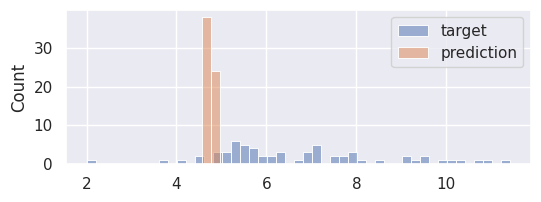

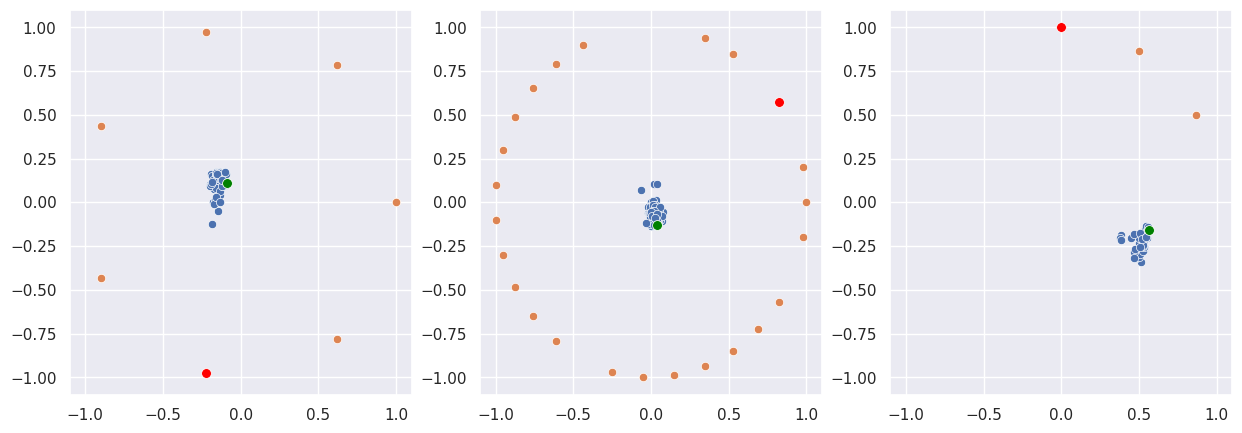

In [265]:
input_sequence, target_sequence = dataset[3]
input_sequence = input_sequence.unsqueeze(0)
pred = model(input_sequence).squeeze(0).detach().numpy()
target = target_sequence.detach().numpy()

print(f'True amount: {np.exp(target[-1, 11]):.2f}')
print(f'Predicted amount: {np.exp(pred[-1, 11]):.2f}')

plotsize(6,2)
sns.histplot(target[:, 11], alpha=0.5, binwidth=0.2, label='target')
sns.histplot(pred[:, 11], alpha=0.5, binwidth=0.2, label='prediction')
plt.legend()
plt.show()

plotsize(15,5)

plt.subplot(1,3,1)
sns.scatterplot(x=pred[:,5], y=pred[:, 6])
sns.scatterplot(x=target[:,5], y=target[:, 6])
sns.scatterplot(x=[pred[-1,5]], y=[pred[-1, 6]], s=50, color='green')
sns.scatterplot(x=[target[-1,5]], y=[target[-1, 6]], s=50, color='red')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.subplot(1,3,2)
sns.scatterplot(x=pred[:,7], y=pred[:, 8])
sns.scatterplot(x=target[:,7], y=target[:, 8])
sns.scatterplot(x=[pred[-1,7]], y=[pred[-1, 8]], s=50, color='green')
sns.scatterplot(x=[target[-1,7]], y=[target[-1, 8]], s=50, color='red')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.subplot(1,3,3)
sns.scatterplot(x=pred[:,9], y=pred[:, 10])
sns.scatterplot(x=target[:,9], y=target[:, 10])
sns.scatterplot(x=[pred[-1,9]], y=[pred[-1, 10]], s=50, color='green')
sns.scatterplot(x=[target[-1,9]], y=[target[-1, 10]], s=50, color='red')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

Text(0, 0.5, 'prediction')

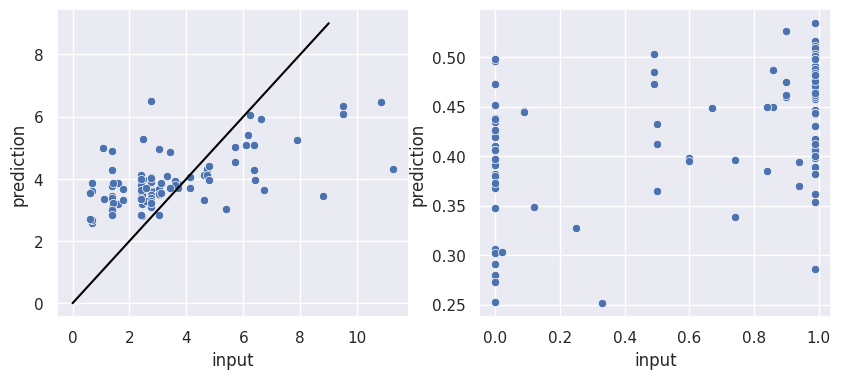

In [501]:
plotsize(10,4)
plt.subplot(1,2,1)
sns.lineplot(x=range(0,10), y=range(0,10), c='black')
sns.scatterplot(x=target[:, 7], y=pred[:, 7])
plt.xlabel('input')
plt.ylabel('prediction')

plt.subplot(1,2,2)
sns.scatterplot(x=target[:, 8], y=pred[:, 8])
plt.xlabel('input')
plt.ylabel('prediction')

In [ ]:
import copy
model_copy = copy.deepcopy(model)

input_sequence, target_sequence = dataset[0]
input_sequence = input_sequence.unsqueeze(0)  # Add batch dimension
attention_weights = get_attention_weights(model_copy, input_sequence)
visualize_attention_weights(attention_weights, input_sequence)

In [63]:
evaluate(model, dataset, test_ix, 10, device)

41.938880920410156

In [235]:
evaluate(model, dataset, test_ix, 20, device)

4.4236973285675045

In [236]:
evaluate(model, dataset, test_ix, 50, device)

4.409394464492798